# Deep Learning with Flux: A 60 Minute Blitz
This is a quick intro to [Flux](https://github.com/FluxML/Flux.jl) loosely
based on [PyTorch's
tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
It introduces basic Julia programming, as well Zygote, a source-to-source 
automatic differentiation (AD) framework in Julia.
We'll use these tools to build a very simple neural network.


## Arrays

The starting point for all of our models is the `Array` (sometimes referred to
as a `Tensor` in other frameworks). This is really just a list of numbers,
which might be arranged into a shape like a square. Let's write down an array
with three elements.

In [1]:
x = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

Here's a matrix – a square array with four elements.

In [2]:
x = [1 2; 3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

We often work with arrays of thousands of elements, and don't usually write
them down by hand. Here's how we can create an array of 5×3 = 15 elements,
each a random number from zero to one.

In [3]:
x = rand(5, 3)

5×3 Matrix{Float64}:
 0.414719  0.256644  0.424936
 0.980868  0.269142  0.507818
 0.641816  0.368848  0.600641
 0.546965  0.723637  0.789636
 0.226999  0.464146  0.669299


There's a few functions like this; try replacing `rand` with `ones`, `zeros`,
or `randn` to see what they do.

By default, Julia works stores numbers is a high-precision format called `Float64`. 

We can ask for more digits using `BigFloat`.

In [4]:
x = rand(BigFloat, 5, 3)

5×3 Matrix{BigFloat}:
 0.216679  0.582942  0.761341
 0.406358  0.270002  0.228995
 0.711244  0.976396  0.363515
 0.568155  0.945878  0.360815
 0.677123  0.832257  0.298957

In ML we often don't need all those digits, and can ask Julia to
work with `Float32` instead. 

In [5]:
x = rand(Float32, 5, 3)

5×3 Matrix{Float32}:
 0.432347  0.621125   0.653302
 0.220424  0.0393736  0.3164
 0.89569   0.662233   0.773545
 0.135044  0.543402   0.460423
 0.976197  0.229174   0.0711092

We can ask the array how many elements it has.

In [6]:
length(x)

15

Or, more specifically, what size it has.


In [7]:
size(x)

(5, 3)

We sometimes want to see some elements of the array on their own.

In [8]:
x[2, 3] # This means get the second row and the third column.

0.3164001f0

In [9]:

x[:, 3] # We can also get every row of the third column.


5-element Vector{Float32}:
 0.6533018
 0.3164001
 0.77354527
 0.46042293
 0.071109176

We can add arrays, and subtract them, which adds or subtracts each element of
the array.

In [10]:
x + x

5×3 Matrix{Float32}:
 0.864694  1.24225    1.3066
 0.440848  0.0787473  0.6328
 1.79138   1.32447    1.54709
 0.270089  1.0868     0.920846
 1.95239   0.458349   0.142218

In [11]:
x - x

5×3 Matrix{Float32}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

Julia supports a feature called *broadcasting*, using the `.` syntax. This
tiles small arrays (or single numbers) to fill bigger ones.


In [12]:
x .+ 1

5×3 Matrix{Float32}:
 1.43235  1.62113  1.6533
 1.22042  1.03937  1.3164
 1.89569  1.66223  1.77355
 1.13504  1.5434   1.46042
 1.9762   1.22917  1.07111


We can see Julia tile the column vector `1:5` across all rows of the larger
array.


In [13]:
zeros(5,5) .+ (1:5)

5×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 2.0  2.0  2.0  2.0  2.0
 3.0  3.0  3.0  3.0  3.0
 4.0  4.0  4.0  4.0  4.0
 5.0  5.0  5.0  5.0  5.0

The x' syntax is used to transpose a column `1:5` into an equivalent row, and
Julia will tile that across columns.

In [14]:
zeros(5,5) .+ (1:5)'

5×5 Matrix{Float64}:
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0

We can use this to make a times table.

In [15]:
(1:5) .* (1:5)'

5×5 Matrix{Int64}:
 1   2   3   4   5
 2   4   6   8  10
 3   6   9  12  15
 4   8  12  16  20
 5  10  15  20  25

Finally, and importantly for machine learning, we can conveniently do things like
matrix multiply.

In [16]:
W = randn(5, 10)
x = rand(10)
W * x

5-element Vector{Float64}:
 -0.6011683736562036
  1.50422059354204
 -0.7541442554886543
 -0.06141451557870048
 -2.5559138118674625

Julia's arrays are very powerful, and you can learn more about what they can
do [here](https://docs.julialang.org/en/v1/manual/arrays/).



# CUDA Arrays

CUDA functionality is provided separately by the [CUDA
package](https://github.com/JuliaGPU/CUDA.jl). If you have a GPU and CUDA
available, you can run `] add CUDA` in a REPL or IJulia to get it.

Once CUDA is loaded you can move any array to the GPU with the `cu`
function, and it supports all of the above operations with the same syntax.


In [17]:
#using CUDA
#x = cu(rand(5, 3))

# Automatic Differentiation
You probably learned to take derivatives in school. We start with a simple
mathematical function like

In [18]:
f(x) = 3x^2 + 2x + 1

f(5)

86

In simple cases it's pretty easy to work out the gradient by hand – here it's
`6x+2`. But it's much easier to make Flux do the work for us!

In [19]:
using Flux: gradient
df(x) = gradient(f, x)[1]
df(5)

32.0

You can try this with a few different inputs to make sure it's really the same
as `6x+2`. We can even do this multiple times (but the second derivative is a
fairly boring `6`).

In [20]:
ddf(x) = gradient(df, x)[1]
ddf(5)

6.0

Flux's AD can handle any Julia code you throw at it, including loops,
recursion and custom layers, so long as the mathematical functions you call
are differentiable. For example, we can differentiate a Taylor approximation
to the `sin` function.

In [21]:
mysin(x) = sum((-1)^k*x^(1+2k)/factorial(1+2k) for k in 0:5)
x = 0.5
mysin(x), gradient(mysin, x),sin(x), cos(x)

(0.4794255386041834, (0.8775825618898637,), 0.479425538604203, 0.8775825618903728)

You can see that the derivative we calculated is very close to `cos(x)`, as we
expect.

This gets more interesting when we consider functions that take *arrays* as
inputs, rather than just a single number. For example, here's a function that
takes a matrix and two vectors (the definition itself is arbitrary)

In [22]:
myloss(W, b, x) = sum(W * x .+ b)

W = randn(3, 5)
b = zeros(3)
x = rand(5)

gradient(myloss, W, b, x)

([0.015792871471235204 0.8467415012906216 … 0.8769955295444761 0.6333324688048757; 0.015792871471235204 0.8467415012906216 … 0.8769955295444761 0.6333324688048757; 0.015792871471235204 0.8467415012906216 … 0.8769955295444761 0.6333324688048757], Fill(1.0, 3), [-0.8375791635624927, 0.34729978883391205, -0.0765920558239151, -1.4671067991202689, -0.8830676743310149])

Now we get gradients for each of the inputs `W`, `b` and `x`, which will come
in handy when we want to train models.

Because ML models can contain hundreds of parameters, Flux provides a slightly
different way of writing `gradient`. We instead mark arrays with `param` to
indicate that we want their derivatives. `W` and `b` represent the weight and
bias respectively.

In [23]:
using Flux: params

W = randn(3, 5)
b = zeros(3)
x = rand(5)

y(x) = sum(W * x .+ b)

grads = gradient(()->y(x), params([W, b]))

grads[W], grads[b]

([0.609060861211633 0.15450230868755077 … 0.28797570889859236 0.14251606583438847; 0.609060861211633 0.15450230868755077 … 0.28797570889859236 0.14251606583438847; 0.609060861211633 0.15450230868755077 … 0.28797570889859236 0.14251606583438847], Fill(1.0, 3))

We can now grab the gradients of `W` and `b` directly from those parameters.

This comes in handy when working with *layers*. A layer is just a handy
container for some parameters. For example, `Dense` does a linear transform
for you.

In [24]:
using Flux

m = Dense(10, 5)

Dense(10 => 5)      # 55 parameters

We can easily get the parameters of any layer or model with params with
`params`.

In [25]:
params(m)

Params([Float32[0.49446166 -0.44929504 … -0.3893069 -0.2850637; -0.6157225 -0.60828245 … -0.50777346 0.4331916; … ; 0.30794078 -0.5372645 … 0.59529155 -0.011852857; 0.3414729 -0.27313283 … -0.14033818 0.3799391], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

This makes it very easy to calculate the gradient for all
parameters in a network, even if it has many parameters.

In [26]:
x = rand(Float32, 10)
m = Chain(Dense(10, 5, relu), Dense(5, 2), softmax)
l(x) = Flux.Losses.crossentropy(m(x), [0.5, 0.5])
grads = gradient(params(m)) do
    l(x)
end
for p in params(m)
    println(grads[p])
end

Float32[0.06718008 0.042710878 0.25918585 0.1593861 0.12761837 0.067326665 0.16037062 0.0043860395 0.10501643 0.14257218; 0.032638848 0.0207507 0.12592314 0.07743632 0.062002257 0.03271006 0.07791464 0.0021309182 0.051021297 0.06926743; 0.0037607027 0.0023909304 0.014509076 0.008922343 0.007144004 0.0037689083 0.008977455 0.00024552798 0.0058787595 0.007981109; -0.04746112 -0.03017421 -0.1831086 -0.112602465 -0.09015933 -0.047564674 -0.113298 -0.0030986317 -0.07419159 -0.10072383; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
Float32[0.32201338, 0.15644734, 0.018026125, -0.22749473, 0.0]
Float32[-0.14869222 -0.31858096 -0.21762851 -0.11862735 -0.0; 0.14869222 0.31858096 0.21762851 0.11862735 0.0]
Float32[-0.2565817, 0.2565817]


You don't have to use layers, but they can be convenient for many simple kinds
of models and fast iteration.

The next step is to update our weights and perform optimisation. As you might be
familiar, *Gradient Descent* is a simple algorithm that takes the weights and steps
using a learning rate and the gradients. `weights = weights - learning_rate * gradient` 
(note that `Flux.Optimise.update!(x, x̄)` already updates with the negative of x̄`).

In [27]:
using Flux.Optimise: update!, Descent
η = 0.1
for p in params(m)
  update!(p, η * grads[p])
end

While this is a valid way of updating our weights, it can get more complicated as the
algorithms we use get more involved.

Flux comes with a bunch of pre-defined optimisers and makes writing our own really simple.
We just give it the learning rate η.

In [28]:
opt = Descent(0.01)

Descent(0.01)

*Training* a network reduces down to iterating on a dataset multiple times, performing these
steps in order. Just for a quick implementation, let’s train a network that learns to predict
`0.5` for every input of 10 floats. `Flux` defines the `train!` function to do it for us.

In [29]:
data, labels = rand(10, 100), fill(0.5, 2, 100)
loss(x, y) = Flux.Losses.crossentropy(m(x), y)
Flux.train!(loss, params(m), [(data,labels)], opt)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 5, relu)
│   summary(x) = 10×100 Matrix{Float64}
└ @ Flux /home/gitpod/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


You don't have to use `train!`. In cases where arbitrary logic might be better suited,
you could open up this training loop like so:

In [30]:
for d in training_set # assuming d looks like (data, labels)
  # our super logic
  gs = gradient(params(m)) do #m is our model
    l = loss(d...)
  end
  update!(opt, params(m), gs)
end

UndefVarError: UndefVarError: `training_set` not defined

# Training a Classifier

Getting a real classifier to work might help cement the workflow a bit more.
[CIFAR10](url) is a dataset of 50k tiny training images split into 10 classes.

We will do the following steps in order:

* Load CIFAR10 training and test datasets
* Define a Convolution Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data

## Loading the Dataset

[Metalhead.jl](https://github.com/FluxML/Metalhead.jl) is an excellent package
that has a number of predefined and pretrained computer vision models.
It also has a number of dataloaders that come in handy to load datasets.

In [31]:
using Statistics
using Flux, Flux.Optimise
using MLDatasets: CIFAR10
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition
#using CUDA

The image will give us an idea of what we are dealing with.

![title](https://pytorch.org/tutorials/_images/cifar10.png)


In [33]:
train_x, train_y = CIFAR10(:train)[:]
labels = onehotbatch(train_y, 0:9)

10×50000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

The train_x contains 50000 images converted to 32 X 32 X 3 arrays with the third
dimension being the 3 channels (R,G,B). Let's take a look at a random image from
the train_x. For this, we need to permute the dimensions to 3 X 32 X 32 and use
`colorview` to convert it back to an image.

Let's take a look at a random image from the dataset

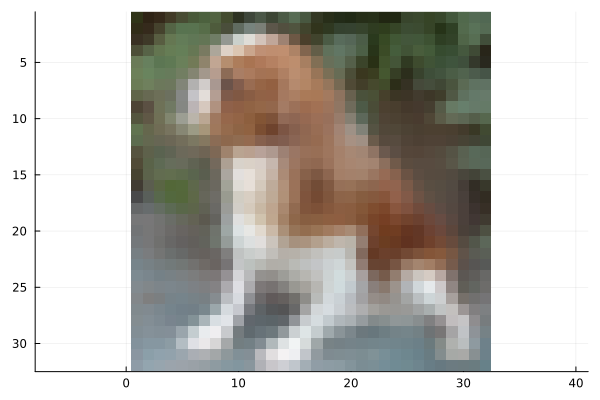

In [34]:
using Plots
image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))
plot(image(train_x[:,:,:,rand(1:end)]))

The images are simply 32 X 32 matrices of numbers in 3 channels (R,G,B). We can now
arrange them in batches of say, 1000 and keep a validation set to track our progress.
This process is called minibatch learning, which is a popular method of training
large neural networks. Rather that sending the entire dataset at once, we break it
down into smaller chunks (called minibatches) that are typically chosen at random,
and train only on them. It is shown to help with escaping
[saddle points](https://en.wikipedia.org/wiki/Saddle_point).

The first 49k images (in batches of 1000) will be our training set, and the rest is
for validation. `partition` handily breaks down the set we give it in consecutive parts
(1000 in this case). 


In [35]:
train = ([(train_x[:,:,:,i], labels[:,i]) for i in partition(1:49000, 1000)])
valset = 49001:50000
valX = train_x[:,:,:,valset]
valY = labels[:, valset]

10×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

## Defining the Classifier
Now we can define our Convolutional Neural Network (CNN).

A convolutional neural network is one which defines a kernel and slides it across a matrix
to create an intermediate representation to extract features from. It creates higher order
features as it goes into deeper layers, making it suitable for images, where the structure of
the subject is what will help us determine which class it belongs to.

In [36]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax)


Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#19#20"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.852 KiB.

We will use a crossentropy loss and the Momentum optimiser here. Crossentropy will be a
good option when it comes to working with multiple independent classes. Momentum smooths out
the noisy gradients and helps towards a smooth convergence. Gradually lowering the 
learning rate along with momentum helps to maintain a bit of adaptivity in our optimisation,
preventing us from overshooting our desired destination.

In [37]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any, Any}())

We can start writing our train loop where we will keep track of some basic accuracy
numbers about our model. We can define an `accuracy` function for it like so.

In [38]:
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))

accuracy (generic function with 1 method)

## Training
Training is where we do a bunch of the interesting operations we defined earlier,
and see what our net is capable of. We will loop over the dataset 10 times and
feed the inputs to the neural network and optimise.

In [39]:
epochs = 10

for epoch = 1:epochs
  for d in train
    gs = gradient(params(m)) do
      l = loss(d...)
    end
    update!(opt, params(m), gs)
  end
  @show accuracy(valX, valY)
end

accuracy(valX, valY) = 0.259


Seeing our training routine unfold gives us an idea of how the network learnt the

This is not bad for a small hand-written network, trained for a limited time.

# Training on a GPU
The `gpu` functions you see sprinkled through this bit of the code tell Flux to move
these entities to an available GPU, and subsequently train on it. No extra faffing
about required! The same bit of code would work on any hardware with some small
annotations like you saw here.

## Testing the Network
We have trained the network for 10 passes over the training dataset. But we need to
check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and
checking it against the ground-truth. If the prediction is correct, we add the sample
to the list of correct predictions. This will be done on a yet unseen section of data.

Okay, first step. Let us perform the exact same preprocessing on this set, as we did
on our training set.

In [ ]:
test_x, test_y = CIFAR10(:test)[:]
test_labels = onehotbatch(test_y, 0:9)

test = [(test_x[:,:,:,i], test_labels[:,i]) for i in partition(1:10000, 1000)]

Next, display an image from the test set.

In [ ]:
plot(image(test_x[:,:,:,rand(1:end)]))

The outputs are energies for the 10 classes. Higher the energy for a class, the more the
network thinks that the image is of the particular class. Every column corresponds to the
output of one image, with the 10 floats in the column being the energies.

Let's see how the model fared.


In [ ]:
ids = rand(1:10000, 5)
rand_test = test_x[:,:,:,ids] |> gpu
rand_truth = test_y[ids]
m(rand_test)

This looks similar to how we would expect the results to be. At this point, it's a good
idea to see how our net actually performs on new data, that we have prepared.

In [ ]:
accuracy(test[1]...)

This is much better than random chance set at 10% (since we only have 10 classes), and
not bad at all for a small hand written network like ours.

Let's take a look at how the net performed on all the classes performed individually.

In [ ]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

The spread seems pretty good, with certain classes performing significantly better than the others.
Why should that be?